## EDA and Modeling - Nicholas Thornton

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_partregress_grid

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


## Data Prep

In [15]:
main_df = pd.read_csv("movie_details_15_to_19.csv")
main_df.head()

/var/folders/jd/kgmmf40n35d3bhgwcsrqn78r0000gn/T/ipykernel_44990/3231863239.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv("movie_details_15_to_19.csv")


,Unnamed: 0,backdrop_path_x,genre_ids,id,original_language_x,original_title_x,overview_x,popularity_x,poster_path_x,release_date_x,...,video_y,vote_average_y,vote_count_y,credits.cast,credits.crew,belongs_to_collection.id,belongs_to_collection.name,belongs_to_collection.poster_path,belongs_to_collection.backdrop_path,matched
0,0,NaN,[99],2203,de,Für ein paar Filme mehr...,NaN,0.0071,NaN,2017-01-01,...,False,0.0,0.0,[],[],NaN,NaN,NaN,NaN,both
1,1,/mJ7YX5VvHdTurXVgnTcXfXe6ZQy.jpg,[18],6636,es,El asaltante,"A man visits a school to enroll his son, but t...",0.5717,/nI7fpYioLcumBOIH0PMPDKxeqZc.jpg,2017-04-01,...,False,5.4,5.0,"[{'adult': False, 'gender': 2, 'id': 50929, 'k...","[{'adult': False, 'gender': 2, 'id': 50922, 'k...",NaN,NaN,NaN,NaN,both
2,2,/5wjCAZ8LrmOsEKS6FcZY8V4AwUM.jpg,"[18, 35]",10148,en,Krystal,A young man living a sheltered life develops a...,4.3749,/5Do7HKvKPgjiBVJieMAOt8aZXAB.jpg,2018-04-13,...,False,5.1,65.0,"[{'adult': False, 'gender': 1, 'id': 5916, 'kn...","[{'adult': False, 'gender': 2, 'id': 63994, 'k...",NaN,NaN,NaN,NaN,both
3,3,/iMYoly1SBrvnuWdDnfW3Szglz1d.jpg,"[35, 18]",10317,en,Our Brand Is Crisis,"Based on the documentary ""Our Brand Is Crisis""...",0.9568,/niDI0NHB11nONifUg8sV6o0mzIk.jpg,2015-09-11,...,False,5.9,514.0,"[{'adult': False, 'gender': 1, 'id': 18277, 'k...","[{'adult': False, 'gender': 2, 'id': 1023495, ...",NaN,NaN,NaN,NaN,both
4,4,/a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg,[27],14564,en,Rings,Julia becomes worried about her boyfriend Holt...,2.2699,/yp4CDOVpVmNwiPoZKQeFCpW8CFo.jpg,2017-02-01,...,False,5.0,2560.0,"[{'adult': False, 'gender': 1, 'id': 1464589, ...","[{'adult': False, 'gender': 1, 'id': 8701, 'kn...",14563.0,The Ring Collection,/500xj7l72BojMZ3tNBJY46tg5YJ.jpg,/jXlFymc442CEMB5h3d62GeJefnW.jpg,both


In [18]:
# Drop index column
if "Unnamed: 0" in main_df.columns:
    main_df = main_df.drop(columns=["Unnamed: 0"])

# Convert release date
main_df["release_date_x"] = pd.to_datetime(main_df["release_date_x"], errors="coerce")
main_df["release_year"] = main_df["release_date_x"].dt.year

# Convert genre list to string
main_df["genre_ids"] = main_df["genre_ids"].astype(str)

# Drop credits (we will use enriched features instead)
main_df = main_df.drop(columns=["credits.cast", "credits.crew"], errors="ignore")

# Drop belongs_to_collection data for now
collection_cols = [col for col in main_df.columns if col.startswith("belongs_to_collection")]
main_df = main_df.drop(columns=collection_cols, errors="ignore")

# Drop duplicate columns like poster_path_x, poster_path_y as needed
dup_cols = [col for col in main_df.columns if col.endswith("_y")]
# We will keep _y for vote_average and vote_count
keep = ["vote_average_y", "vote_count_y"]
drop = [col for col in dup_cols if col not in keep]
main_df = main_df.drop(columns=drop, errors="ignore")

# Drop rows with missing id
main_df = main_df.dropna(subset=["id"])
main_df = main_df.drop_duplicates(subset=["id"])

# Keep the TMDB detail scraper ratings
main_df = main_df.drop(columns=["vote_average_x", "vote_count_x"], errors="ignore")

# Rename vote_average_y and vote_count_y to simpler names
main_df = main_df.rename(columns={
    "vote_average_y": "vote_average",
    "vote_count_y": "vote_count"
})

# Rename other _x columns to normal names
main_df = main_df.rename(columns={
    "backdrop_path_x": "backdrop_path",
    "original_language_x": "original_language",
    "original_title_x": "original_title",
    "overview_x": "overview",
    "popularity_x": "popularity",
    "poster_path_x": "poster_path",
    "release_date_x": "release_date",
    "title_x": "title",
    "video_x": "video"
})

main_df.head()


,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,production_countries,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,matched,release_year
0,NaN,[99],2203,de,Für ein paar Filme mehr...,NaN,0.0071,NaN,2017-01-01,Für ein paar Filme mehr...,...,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]",0.0,30.0,[],Released,NaN,0.0,0.0,both,2017
1,/mJ7YX5VvHdTurXVgnTcXfXe6ZQy.jpg,[18],6636,es,El asaltante,"A man visits a school to enroll his son, but t...",0.5717,/nI7fpYioLcumBOIH0PMPDKxeqZc.jpg,2017-04-01,The Mugger,...,"[{'iso_3166_1': 'AR', 'name': 'Argentina'}]",0.0,67.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,5.4,5.0,both,2017
2,/5wjCAZ8LrmOsEKS6FcZY8V4AwUM.jpg,"[18, 35]",10148,en,Krystal,A young man living a sheltered life develops a...,4.3749,/5Do7HKvKPgjiBVJieMAOt8aZXAB.jpg,2018-04-13,Krystal,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,She turns men into boys and boys into men.,5.1,65.0,both,2018
3,/iMYoly1SBrvnuWdDnfW3Szglz1d.jpg,"[35, 18]",10317,en,Our Brand Is Crisis,"Based on the documentary ""Our Brand Is Crisis""...",0.9568,/niDI0NHB11nONifUg8sV6o0mzIk.jpg,2015-09-11,Our Brand Is Crisis,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",7002261.0,107.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,May the best campaign win.,5.9,514.0,both,2015
4,/a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg,[27],14564,en,Rings,Julia becomes worried about her boyfriend Holt...,2.2699,/yp4CDOVpVmNwiPoZKQeFCpW8CFo.jpg,2017-02-01,Rings,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",83080890.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,First you watch it. Then you die.,5.0,2560.0,both,2017


In [7]:
enriched_df = pd.read_csv("data/movies_15_to_19_enriched.csv")
details_df = pd.read_csv("data/movie_details_database.csv")
genre_df = pd.read_csv("data/movie_genre_database.csv")

In [8]:
enriched_df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,...,review_mean_neu_sentiment,review_mean_pos_sentiment,review_mean_compound_sentiment,movie_id,gender_split,max_popularity,min_popularity,avg_popularity,median_popularity,num_cast
0,False,/7kGhq8nROnNGw6uZoUMFSe389VL.jpg,"[10749, 18]",271039,en,"Something, Anything",When a tragedy shatters her plans for domestic...,12.0941,/xmqqgTz5ceMjoFMe831WXtEDKsc.jpg,2015-01-09,...,1.000000,0.000000,0.000000,271039.0,0.428571,1.0347,0.0193,0.354657,0.03790,7.0
1,False,/8jnHGZ4vguLcctDHlMvaAyG7mjb.jpg,"[16, 878, 28]",296917,ja,劇場版 PSYCHO-PASS サイコパス,"In a futuristic Japan, the Sibyl System is cha...",9.3462,/hUlhPosXp62uuTS0c2aINdg8cvV.jpg,2015-01-09,...,0.457714,0.000000,-0.339829,296917.0,NaN,3.1799,0.1421,1.360221,1.13675,24.0
2,False,/pw9oCxdHISiiWYjthGO9iXXcVtw.jpg,"[18, 14, 53]",312849,tr,Sarmaşık,"After the owner's bankruptcy, the crew is stra...",8.6511,/jsqgoFLDX4o0dNkdjB8UG83Rzng.jpg,2015-01-26,...,NaN,NaN,NaN,312849.0,0.125000,1.7608,0.0168,0.654975,0.55140,8.0
3,False,/qzUIOTk0E3F1zjvYjcBRTKUTgf9.jpg,"[80, 35, 28, 12]",207703,en,Kingsman: The Secret Service,The story of a super-secret spy organization t...,8.1795,/r6q9wZK5a2K51KFj4LWVID6Ja1r.jpg,2015-01-24,...,0.606556,0.393444,0.200878,207703.0,0.176471,8.6556,0.0214,1.167616,0.52930,51.0
4,False,/2KBm2Q6NzwdtOH5Gav9WgkdHlpw.jpg,[18],336806,sv,Efterskalv,When John returns home to his father after ser...,7.7409,/taRuclzevcoTBNlT72rlfdILxsd.jpg,2015-01-20,...,0.725000,0.000000,-0.230267,336806.0,0.466667,1.2933,0.0143,0.183733,0.07190,15.0


In [21]:
[col for col in main_df.columns if col == "id"]


['id']

In [26]:
enriched_df = enriched_df.rename(columns={"movie_id": "id"})


In [ ]:
# Remove the old id if it exists
if "id" in enriched_df.columns:
    enriched_df = enriched_df.drop(columns=["id"])

# Rename movie_id to id
enriched_df = enriched_df.rename(columns={"movie_id": "id"})

# Safety: ensure no duplicates
enriched_df = enriched_df.loc[:, ~enriched_df.columns.duplicated()]



In [ ]:
merged_df = main_df.merge(
    enriched_df[
        [
            "id",
            "gender_split",
            "max_popularity",
            "min_popularity",
            "avg_popularity",
            "median_popularity",
            "num_cast",
            "review_mean_neg_sentiment",
            "review_mean_neu_sentiment",
            "review_mean_pos_sentiment",
            "review_mean_compound_sentiment"
        ]
    ],
    on="id",
    how="left"
)

merged_df.shape


(152774, 37)

In [35]:
merged_df.head()


,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,gender_split,max_popularity,min_popularity,avg_popularity,median_popularity,num_cast,review_mean_neg_sentiment,review_mean_neu_sentiment,review_mean_pos_sentiment,review_mean_compound_sentiment
0,NaN,[99],2203,de,Für ein paar Filme mehr...,NaN,0.0071,NaN,2017-01-01,Für ein paar Filme mehr...,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,/mJ7YX5VvHdTurXVgnTcXfXe6ZQy.jpg,[18],6636,es,El asaltante,"A man visits a school to enroll his son, but t...",0.5717,/nI7fpYioLcumBOIH0PMPDKxeqZc.jpg,2017-04-01,The Mugger,...,NaN,0.3286,0.0143,0.148433,0.13320,6.0,0.000000,1.000000,0.0,0.000000
2,/5wjCAZ8LrmOsEKS6FcZY8V4AwUM.jpg,"[18, 35]",10148,en,Krystal,A young man living a sheltered life develops a...,4.3749,/5Do7HKvKPgjiBVJieMAOt8aZXAB.jpg,2018-04-13,Krystal,...,NaN,5.4422,0.5232,2.161545,2.15060,11.0,0.102500,0.897500,0.0,-0.025517
3,/iMYoly1SBrvnuWdDnfW3Szglz1d.jpg,"[35, 18]",10317,en,Our Brand Is Crisis,"Based on the documentary ""Our Brand Is Crisis""...",0.9568,/niDI0NHB11nONifUg8sV6o0mzIk.jpg,2015-09-11,Our Brand Is Crisis,...,0.05,8.5361,0.0338,1.630175,0.82550,20.0,0.000000,1.000000,0.0,0.000000
4,/a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg,[27],14564,en,Rings,Julia becomes worried about her boyfriend Holt...,2.2699,/yp4CDOVpVmNwiPoZKQeFCpW8CFo.jpg,2017-02-01,Rings,...,0.05,2.6744,0.1412,1.132125,0.81845,20.0,0.228824,0.771176,0.0,-0.139276


## Data Visualization
Using Vote_Average as Y

In [36]:
y = merged_df["vote_average"]
merged_df["vote_average"].isna().sum()


np.int64(3)

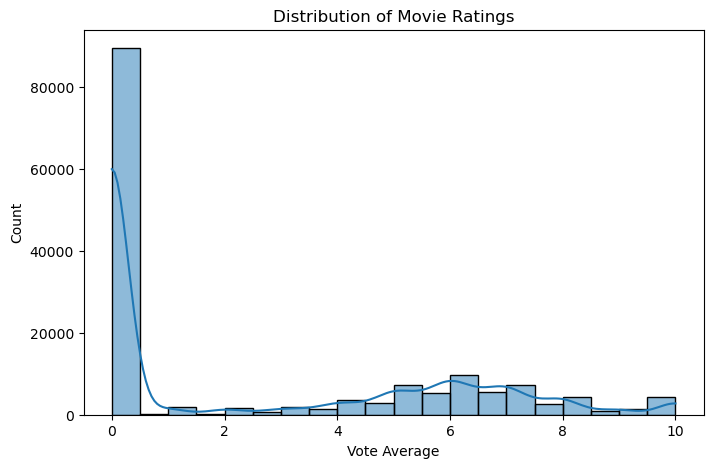

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(merged_df["vote_average"], bins=20, kde=True)
plt.xlabel("Vote Average")
plt.title("Distribution of Movie Ratings")
plt.show()


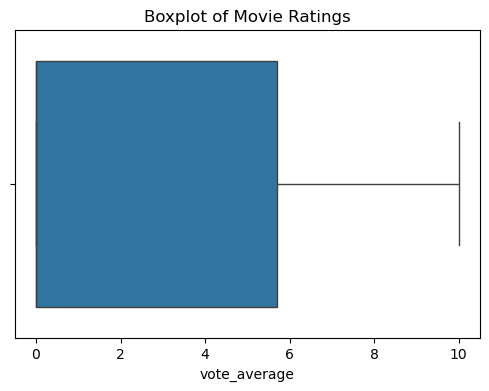

In [38]:
plt.figure(figsize=(6,4))
sns.boxplot(x=merged_df["vote_average"])
plt.title("Boxplot of Movie Ratings")
plt.show()


In [39]:
merged_df["vote_average"].describe()


count    152771.000000
mean          2.491601
std           3.241916
min           0.000000
25%           0.000000
50%           0.000000
75%           5.705000
max          10.000000
Name: vote_average, dtype: float64

In [40]:
merged_df["vote_average"] = merged_df["vote_average"].replace(0, np.nan)
merged_df["vote_average"].describe()


count    63224.000000
mean         6.020568
std          2.036993
min          0.500000
25%          5.000000
50%          6.000000
75%          7.100000
max         10.000000
Name: vote_average, dtype: float64